In [1]:
from ga.ga_hlm import *
from hlm_basic.ssn import GenerateNetwork, UpstreamArea
from hlm_basic.watershed import Watershed
from hlm_basic.tools import GetForcing, Set_InitialConditions, plot_sim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
l_id, connectivity, h_order, nextlink = GenerateNetwork(5)
n_hills = len(connectivity)
a_hill = 0.5 * 0.5 #km2
A_h = np.array([a_hill*10**6 for i in range(n_hills)]) #m2
L_i = np.array([0.5*10**3 for i in range(n_hills)])  #m
A_i = UpstreamArea(a_hill, connectivity, h_order) #km2

In [3]:
forcing, raw_data = GetForcing("../data/rainfall/2010_timeseries.csv", '2010-06-01','2010-08-01')
te = len(forcing)-1

In [4]:
dams = [9,27,36,45,63,90,108,117,126,135,144,153,171,189,198,207,216,225,234] 
order_3 = [9,36,45,63,90,117,126,144,153,171,198,207,225,234] 
order_4 = [27, 189, 216, 135, 108]
n_dams = len(dams)
# Parameters of each dam (For Model 256)
_alpha = [0.5 for _ in range(n_dams)]
c1 = [0.6 for _ in range(n_dams)]
c2 = [1.66 for _ in range(n_dams)]

H_spill = []
H_max = []
diam = []
S_max = []
L_spill = []
L_crest = []
for dam in dams:
    if dam in order_3:
        H_spill.append(4.5)
        H_max.append(5)
        diam.append(0.75)
        S_max.append(200000)
        L_spill.append(2.0)
        L_crest.append(5.0)
    elif dam in order_4:
        H_spill.append(4.5)
        H_max.append(5.0)
        diam.append(1.0)
        S_max.append(300000)
        L_spill.append(4.0)
        L_crest.append(10.0)
        

In [5]:
SSN1 = Watershed(Model=254)
SSN1.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
SSN1.initialize(q=q, s_p=s_p, s_t=s_t, s_s=s_s)
dc_nodam = SSN1.Run_254( [0, te],forcing, rtol=1e-6,)

Model 254 is being used!
87839

In [25]:
SSN3 = Watershed(Model=256)
SSN3.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN3.dam_ids = dams
dam_params256 = SSN3.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN3.set_dam_state(states=[1 for _ in range(n_dams)])
SSN3.initialize(q=q, S = S, s_t =s_t, s_p =s_p, s_s=s_s)

dc_passiveVAR, st_passiveVAR = SSN3.Run_256( [0, te], forcing, dam_params256)

Model 255 (254 with_dams) is being used!
87839

In [5]:
def Quad_Params(threshold, reward):
    '''Parameters of a concave quadratic equation whose vertex is on the
    point of (threshold, reward)
    eq: ax2 + bx +c
    returns the parameters a, b, c 
    '''
    a = -2 * reward / threshold ** 2
    b = 4 * reward / threshold
    c = -reward
    return a, b, c

In [6]:
eq235 = Quad_Params(21.2,10)
eq217 = Quad_Params(20.2, 10)
eq181 = Quad_Params(18.2, 10)
eq73 = Quad_Params(10.5, 10)
eq55 = Quad_Params(8, 10)
eq19 = Quad_Params(5, 10)

def FitnessCalculator1(sim_data):

    fitnesses = np.array([])
    for data in sim_data:
        fitness = 0
        flow = data[0]
        storage = data[1]
        order_3 = ['9','36','45','63','90','117','126','144','153','171','198','207','225','234'] 
        order_4 = ['27', '189', '216', '135', '108']
        dam3_over = (storage[order_3]>200000).values.sum()
        dam4_over = (storage[order_4]>300000).values.sum()

        fitness += -dam3_over*20 -dam4_over*50
        fitness += eq235[0]*flow['8']**2 + eq235[1]*flow['8'] + eq235[2]
        fitness += eq217[0]*flow['26']**2 + eq217[1]*flow['26'] + eq217[2]
        fitness += eq181[0]*flow['62']**2 + eq181[1]*flow['62'] + eq181[2]
        fitness += eq73[0]*flow['89']**2 + eq73[1]*flow['89'] + eq73[2]
        fitness += eq73[0]*flow['170']**2 + eq73[1]*flow['170'] + eq73[2]
        fitness += eq55[0]*flow['107']**2 + eq55[1]*flow['107'] + eq55[2]
        fitness += eq55[0]*flow['188']**2 + eq55[1]*flow['188'] + eq55[2]
        fitness += eq19[0]*flow['35']**2 + eq19[1]*flow['35'] + eq19[2]
        fitness += eq19[0]*flow['143']**2 + eq19[1]*flow['143'] + eq19[2]
        fitness += eq19[0]*flow['116']**2 + eq19[1]*flow['116'] + eq19[2]
        fitness += eq19[0]*flow['197']**2 + eq19[1]*flow['197'] + eq19[2]
        fitness += eq19[0]*flow['234']**2 + eq19[1]*flow['234'] + eq19[2]

        fitnesses = np.append(fitnesses, fitness)
        # print('fitness in Calculator: ', fitness )
    return fitnesses

In [69]:
def FitnessCalculator(sim_data):
    '''Calculates fitness of the individuals'''
    fitnesses = np.array([])
    for data in sim_data:
        fitness = 0
        flow = data[0]
        storage = data[1]
        dam_over = (storage>=200000).values.sum()
        
        fitness += 100/flow['0']
        fitness -= dam_over*100
        fitnesses = np.append(fitnesses, fitness)
        # print('fitness in Calculator: ', fitness )
    return fitnesses

def RunSimulation(object, state , t0, forcing, dam_parameters, t_next):

    object.set_dam_state(states=state)
    dc_test, st_test = object.Run_256( [t0, t0+t_next], forcing, dam_parameters)
    flow_max = dc_test.max(axis=0)
    volume_max = st_test.max(axis=0)
    return [dc_test, st_test]#, [flow_max, volume_max]#, [dc_test, st_test]

In [70]:
SSN5 = Watershed(Model=255)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]
SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)

Model 255 (254 with_dams) is being used!


In [71]:
population = InitialPopulation(10, n_dams)
for state in population[:1]:
    sim= RunSimulation(SSN5, state , 0, forcing, dam_params256,5000)

5000

In [122]:
def InitialPopulation2(n_chromosomes, n_genes):
    '''
    Returns a 2D numpy array consisting of numbers in [0, 0.25, 0.50, 0.75, 1.0] 
    with a size of (n_chromosomes, n_genes)
    '''
    init_pop = np.random.choice([0, 0.25, 0.50, 0.75, 1], size=(n_chromosomes, n_genes))
    np.random.shuffle(init_pop)
    init_pop[0] = np.array([1 for _ in range(n_genes)])
    return init_pop

In [124]:
InitialPopulation2(10, 15)

array([[1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
        1.  , 1.  , 1.  , 1.  ],
       [1.  , 0.25, 0.  , 0.5 , 0.75, 0.  , 0.25, 0.  , 0.  , 0.5 , 0.  ,
        0.75, 0.  , 0.75, 0.5 ],
       [0.25, 0.25, 0.75, 0.  , 1.  , 0.25, 0.75, 0.25, 0.  , 0.25, 0.75,
        1.  , 0.25, 0.25, 1.  ],
       [0.75, 0.75, 0.25, 0.75, 0.  , 0.25, 1.  , 0.25, 0.25, 0.75, 0.75,
        1.  , 0.5 , 1.  , 0.25],
       [1.  , 0.25, 0.25, 0.  , 0.25, 0.  , 0.5 , 0.  , 0.5 , 0.25, 1.  ,
        0.5 , 0.25, 0.75, 1.  ],
       [0.  , 0.25, 0.25, 0.  , 0.25, 0.75, 0.25, 0.75, 0.75, 0.5 , 1.  ,
        1.  , 0.75, 0.5 , 0.25],
       [0.75, 0.  , 0.  , 0.5 , 0.75, 0.5 , 0.5 , 0.75, 0.75, 0.  , 1.  ,
        0.75, 0.  , 0.75, 0.  ],
       [1.  , 0.25, 0.5 , 1.  , 0.  , 1.  , 0.75, 0.5 , 0.75, 0.25, 0.75,
        1.  , 0.25, 1.  , 0.  ],
       [1.  , 1.  , 0.25, 0.5 , 0.5 , 0.  , 0.75, 0.5 , 0.  , 0.5 , 1.  ,
        0.5 , 0.25, 0.5 , 0.  ],
       [0.25, 0.25, 1.  , 0.25, 0.  ,

In [117]:
np.where(np.all(population==[0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0],axis=1))[0][0]

9

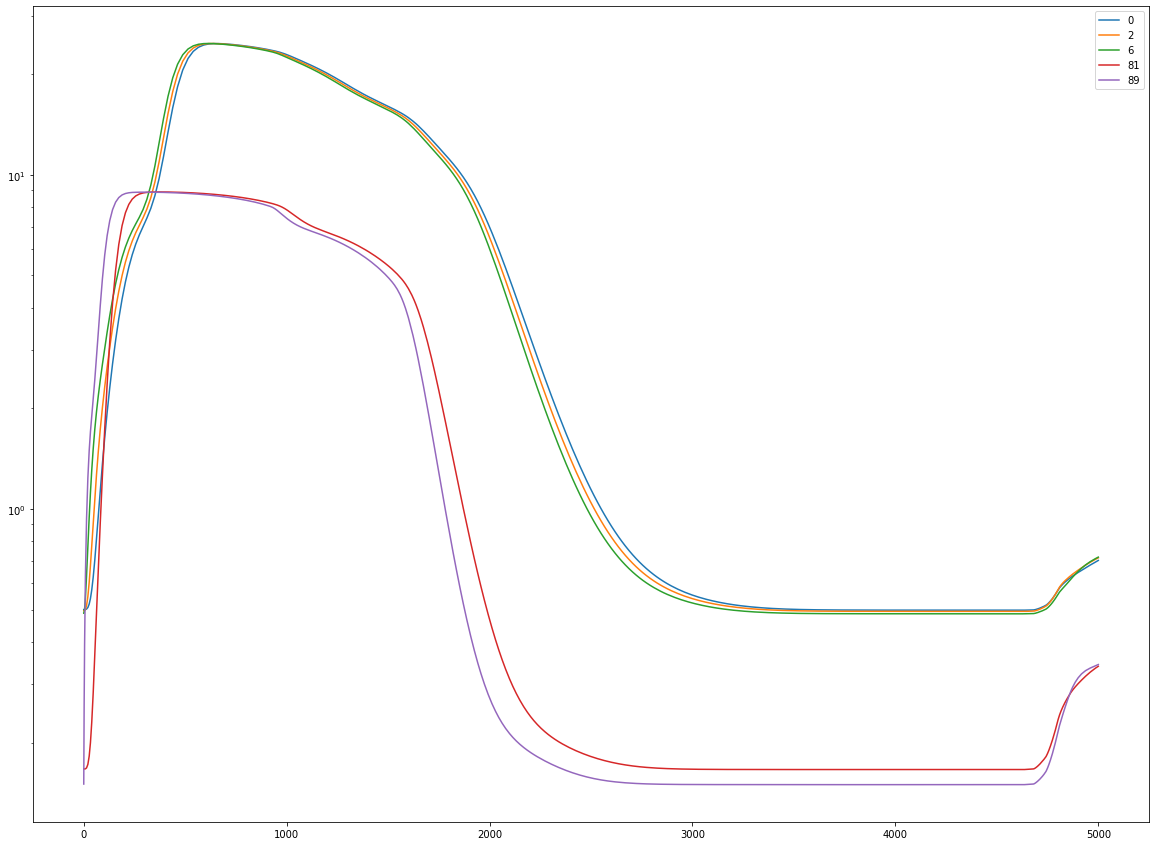

In [118]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.set_yscale('log')
sim[0].plot(y='0', ax=ax)
sim[0].plot(y='2', ax=ax)
sim[0].plot(y='6', ax=ax)
sim[0].plot(y='81', ax=ax)
sim[0].plot(y='89', ax=ax)




In [ ]:
SSN5 = Watershed(Model=255)
SSN5.init_custom(links=l_id, connectivity=connectivity, A_i=A_i, L_i=L_i, A_h=A_h)
SSN5.dam_ids = dams
dam_params256 = SSN5.init_dam_params256(H_spill, H_max, S_max, _alpha, diam, c1, c2, L_spill, L_crest)
q, s_p, s_t, s_s = Set_InitialConditions(0.5, A_i[0], A_i)
S = [100000 for _ in range(n_dams)]

update = 60#mins
t0 = 0
fitness_overtime = []
columns = SSN5.__columns__()
dc_ga = pd.DataFrame(columns =columns[0])
st_ga  = pd.DataFrame(columns =columns[1])
while t0 < te-60:
    if t0 !=0:
        q, S, s_p, s_t, s_s = SSN5.Get_Snapshot()
    
    population = InitialPopulation(10, n_dams)
    SSN5.initialize(q=q, S=S, s_p=s_p,s_t =s_t, s_s=s_s)
    data = RunSimulation(SSN5, population[0] , t0, forcing, dam_params256, 120)
    flow = data[0]
    if flow['8']>31.80/2 or flow['26']>30.40/2 or flow['62']>27.4/2 or flow['89']>16.33/2 or flow['170']>16.33/2:
 
        generation = 0
        # sim_results = []
        while generation<15: # generation
            sim_data = []
            
            for state in population:
                sim= RunSimulation(SSN5, state , t0, forcing, dam_params256,60)
                # flow = sim[0]
                # storage = sim[1]
                # print(state)
                # print('Max Flow at 0: ', flow['0'])
                # print('Dams Overtopped: ',(storage>=200000).values.sum(), 'MaxVol: ',storage.max())
                # print('fitness: ',FitnessCalculator(sim))
                sim_data.append(sim)
                # sim_results.append((state,sim_result))
            fitnesses = FitnessCalculator1(sim_data)
            # print(f'G:{generation}: {fitnesses}')
            idx = np.argmax(fitnesses)
            # print(f'best_idx: {idx}')
            fitness_overtime.append(fitnesses[idx])
            parents = MatingPoolSelection(population, fitnesses, n_parents=None, selection='best', k=3)
            offsprings = Crossover(parents, operator='uniform')
            # print(f'P:{parents}')
            # print(f'O:{offsprings}')            
            offsprings = MutateOffspring(offsprings, method='scrample', p=0.15)
            population = NewPopulation(parents, offsprings)
            generation +=1
        state = population[idx].astype(int).tolist()
        print(t0, ' >>> ', state, 'fitness>>', fitnesses[idx])
    else:
        state = [1 for _ in range(n_dams)]
        # print(t0, ' >>> ', state, )
    
    SSN5.set_dam_state(states=state)
    try:
        dc, st = SSN5.Run_256([t0, t0+update], forcing, dam_params256,)
    except IndexError:
        break
    t0 += update
    dc_ga = dc_ga.append(dc)
    st_ga = st_ga.append(st)

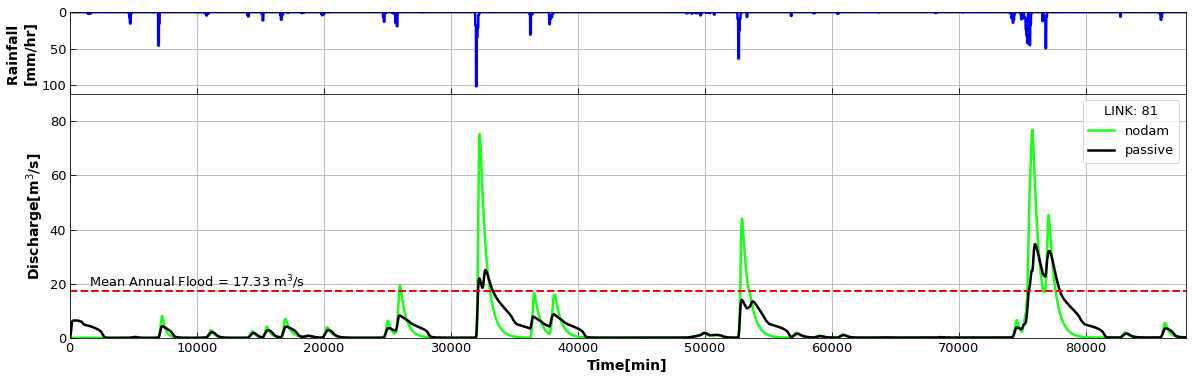

In [26]:
s_name = '_h45_5_O75_1_10_19dams' 
pltKwargs = [{'label':'nodam', 'color':'#1AFF1A'}, {'label':'passive', 'color':'k'}]
plot_sim(81, forcing, [dc_nodam, dc_passive], pltKwargs, d_type='discharge', discharge_axis=[0,90,20], area=20.25, save='../../Supp_DamStudy/Hydro81'+s_name)

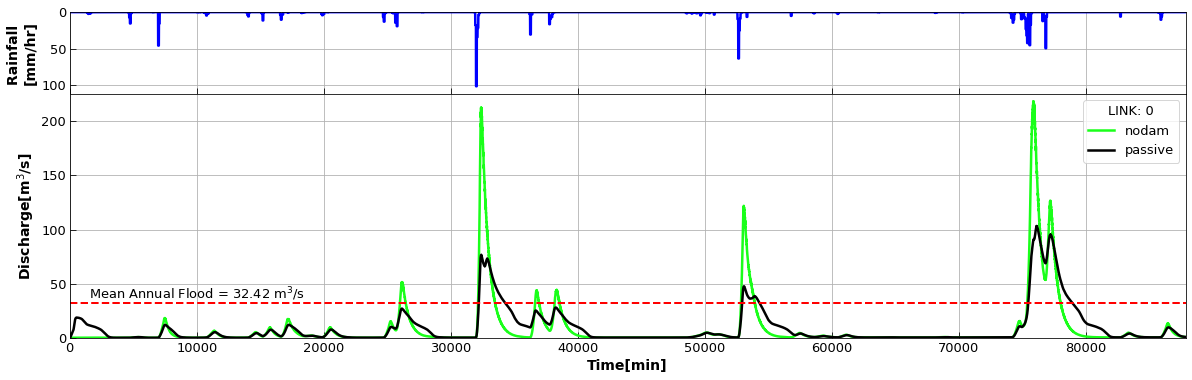

In [27]:
plot_sim(0, forcing, [dc_nodam, dc_passive], pltKwargs, d_type='discharge', discharge_axis=[0,225,50], area=60.75, save='../../Supp_DamStudy/Hydro0'+s_name)

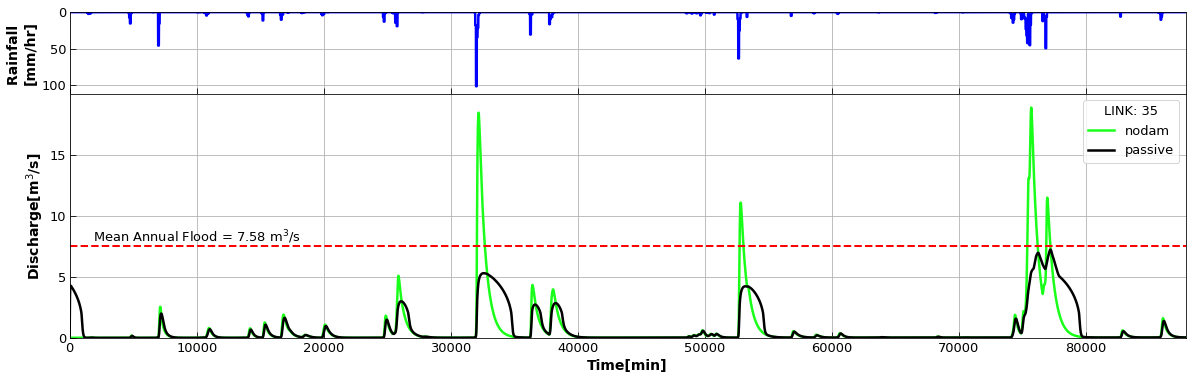

In [28]:
plot_sim(35, forcing, [dc_nodam, dc_passive], pltKwargs, d_type='discharge', discharge_axis=[0,20,5], area=4.75, save='../../Supp_DamStudy/Hydro35'+s_name)

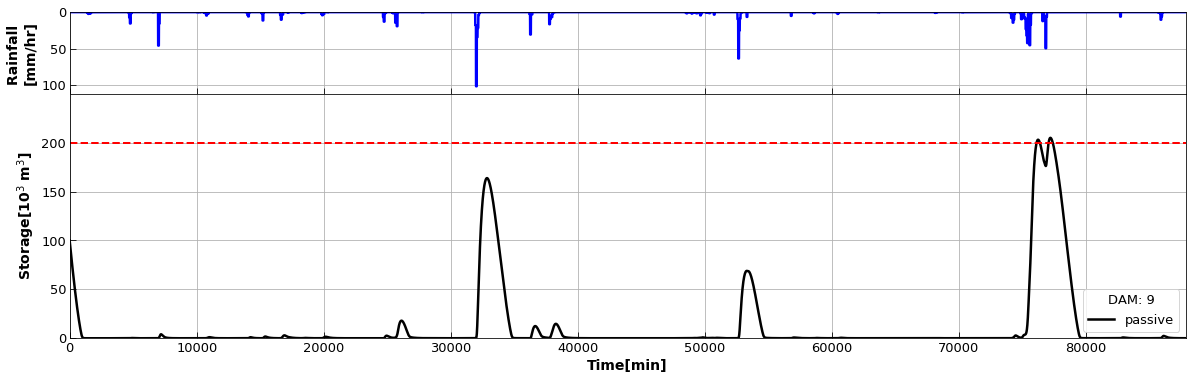

In [29]:
plot_sim(9, forcing, [st_passive], [pltKwargs[1]], d_type='storage', save='../../Supp_DamStudy/Vol9'+s_name)


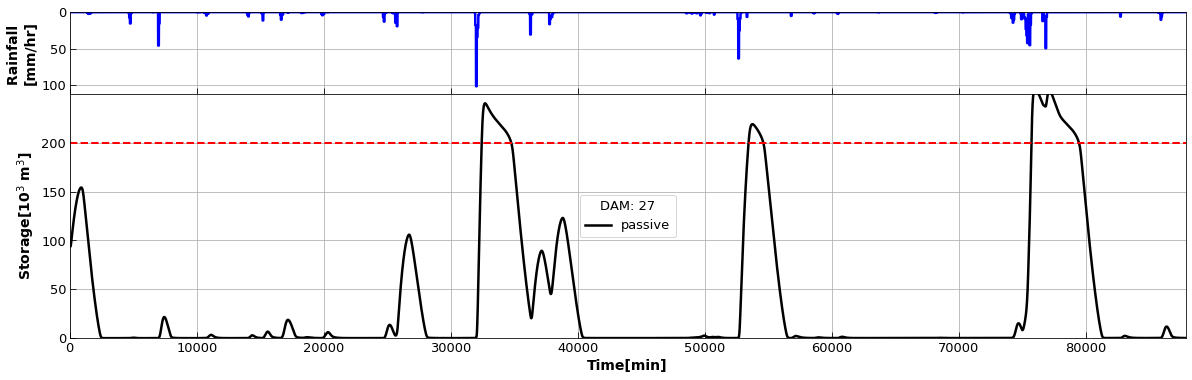

In [30]:
plot_sim(27, forcing, [st_passive], [pltKwargs[1]], d_type='storage', save='../../Supp_DamStudy/Vol27'+s_name)

In [47]:

from imp import reload 
import hlm_basic
reload(hlm_basic.tools)
from hlm_basic.tools import plot_sim